In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [25]:
session_info = {'date': "10_02_2024",
                'genotype_dir': 'EPG_jGCaMP7b_VK05',
                'fly': 'fly4',
                'session': 'mianserin_dark-004',
                'full_genotype': '+/w-; +/EPG-AD; UAS-jGCaMP7b^{vk00005}/EPG-DBD (SS00096)',
                'ecl date': '2/3-4/2024',
                'notes': ''}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)

In [26]:
if True:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]
    pp.extract_timeseries(max_proj=True)
    y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)
    print(pp.session_info)

{'date': '10_02_2024', 'genotype_dir': 'EPG_jGCaMP7b_VK05', 'fly': 'fly4', 'session': 'mianserin_dark-004', 'full_genotype': '+/w-; +/EPG-AD; UAS-jGCaMP7b^{vk00005}/EPG-DBD (SS00096)', 'ecl date': '2/3-4/2024', 'notes': '50 microM mianserin'}


In [11]:
# pp.session_info['notes']='control saline'
# print(pp.session_info)

In [3]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=2, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()
nap = pp.open_napari()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [4]:
print('')

In [6]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [7]:
np.isnan(pp.timeseries['rois']).sum()

0

In [8]:
y = pp.calculate_zscored_F('rois', exp_detrend=True)

In [27]:
pp.save()

In [28]:
# y_sm = sp.ndimage.gaussian_filter1d(-1*sp.ndimage.gaussian_filter1d(y, 1, axis=-1),.7,axis=1, mode='wrap')
y_sm = sp.ndimage.gaussian_filter1d(y-1, 1, axis=-1)

x_f,y_f = st2p.utilities.pol2cart(y_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()

_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

(3287,) (3287,)


Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')
(1, 16, 3287) (3287,)


(array([ 16., 224., 630., 305., 219., 631., 783.,  93.,  43.,  47.]),
 array([-3.10351894, -2.49033932, -1.8771597 , -1.26398008, -0.65080046,
        -0.03762084,  0.57555878,  1.1887384 ,  1.80191802,  2.41509763,
         3.02827725]),
 <BarContainer object of 10 artists>)

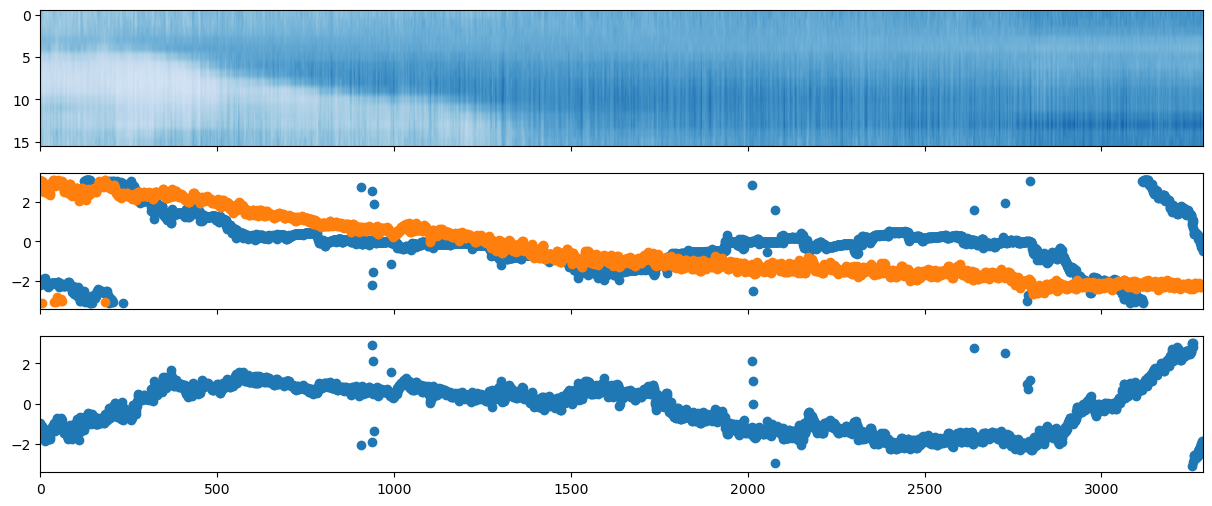

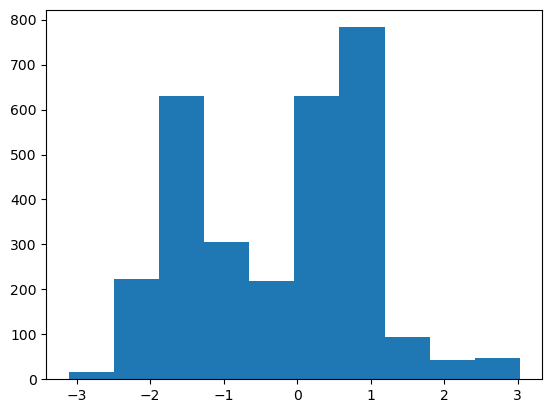

In [29]:
fig, ax= plt.subplots(3,1, figsize=[15,6], sharex=True)
ax[0].imshow(y_sm[0,::-1,:], aspect='auto', cmap= 'Blues', vmin=-1, vmax=1)
# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
print(y.shape, heading.shape)
ax[1].scatter(x,heading)
ax[1].scatter(x, phi)
ax[2].scatter(x, offset)

mask = (heading>-3*np.pi/4) & (heading<3*np.pi/4)
fig, ax= plt.subplots()
ax.hist(offset[mask])

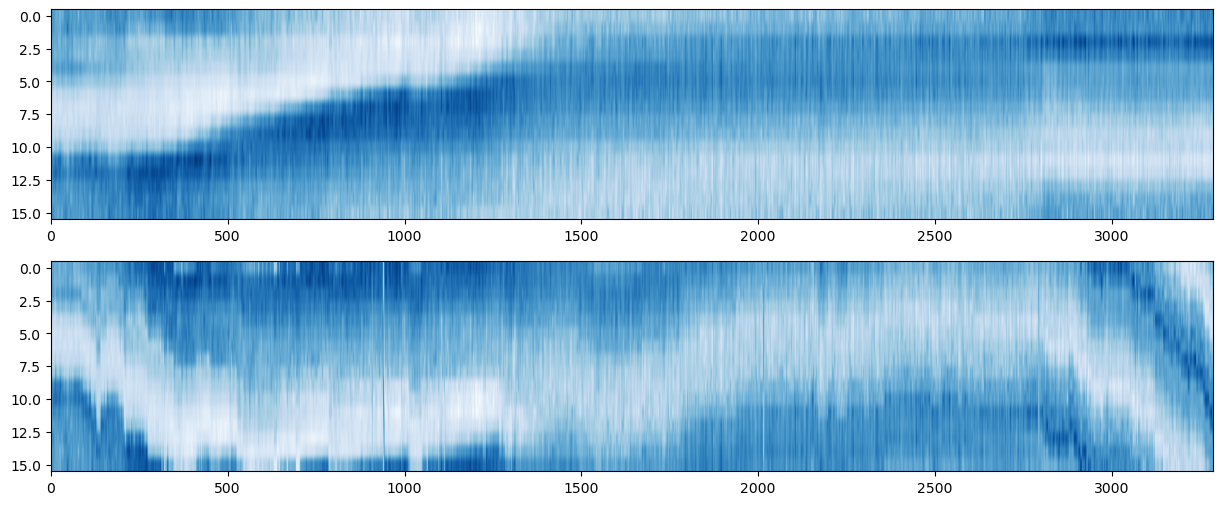

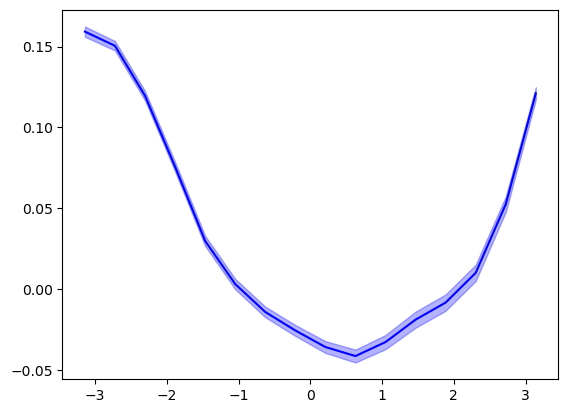

In [30]:
heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)
# print(heading_ind, y_sm.shape)

y_sm_heading_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_sm_heading_aligned[0,:,ind] = np.roll(y_sm[0,:,ind], -heading_ind[ind])
    
fig, ax= plt.subplots(2,1, figsize=[15,6])
ax[0].imshow(y_sm[0,:, :] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')
ax[1].imshow(y_sm_heading_aligned[0,:,:] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')

# y_sm_ha = y
mu = y_sm_heading_aligned[:,:,:].mean(axis=-1)[0,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,:], axis=-1)[0,:]
# print(mu.shape, sem.shape)
# fig, ax = plt.subplots()
# ax.imshow(y_sm_heading_aligned[:,:,mask][0,:,:], cmap='Blues', aspect='auto')

fig, ax= plt.subplots()
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')

In [31]:
print(sp.stats.circvar(offset))

0.5330192637037384
